```TODO: fare log della lunghezza dell'episodio, ogni episodio (praticamente insieme alla running avg loggare anche len(episode))```

```TODO: Rendere opzionale la visualizzazione ```

# Deep Reinforcement Learning Laboratory

In this laboratory session we will work on getting more advanced versions of Deep Reinforcement Learning algorithms up and running. Deep Reinforcement Learning is **hard**, and getting agents to stably train can be frustrating and requires quite a bit of subtlety in analysis of intermediate results. We will start by refactoring (a bit) my implementation of `REINFORCE` on the [Cartpole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/). 

## Exercise 1: Improving my `REINFORCE` Implementation (warm up)

In this exercise we will refactor a bit and improve some aspects of my `REINFORCE` implementation. 

**First Things First**: Spend some time playing with the environment to make sure you understand how it works.

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.distributions import Categorical
import matplotlib.pyplot as plt
# Instantiate a rendering and a non-rendering environment.
env_render = gym.make('CartPole-v1', render_mode='human')
env = gym.make('CartPole-v1')

In [3]:
# Your code here. Call .reset() on the environment and inspect the output. Also, check out the observation_space.
(obs, info) = env.reset()
print(obs)
print(obs.shape)
print(env.observation_space)
print(env.action_space)

[-0.03797098  0.03580978  0.02704508  0.03921853]
(4,)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Discrete(2)


**Next Things Next**: Now get your `REINFORCE` implementation working on the environment. You can import my (probably buggy and definitely inefficient) implementation here. Or even better, refactor an implementation into a separate package from which you can `import` the stuff you need here. 

In [10]:
# Your code here. You should be able to train an agent to solve Cartpole. This will be our starting point.

In [18]:
# A simple, but generic, policy network with one hidden layer.
class PolicyNet(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], 16)
        self.fc2 = nn.Linear(16, env.action_space.n)
        self.relu = nn.ReLU()
        
    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = F.softmax(self.fc2(s), dim=-1)
        return s


In [19]:
# A simple, but generic, policy network with one hidden layer.
class ValueNet(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], 16)
        self.fc2 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        
    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = self.fc2(s)
        return s

In [20]:
# Given an environment, observation, and policy, sample from pi(a | obs). Returns the
# selected action and the log probability of that action (needed for policy gradient).
def select_action(env, obs, policy):
    dist = Categorical(policy(obs))
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return (action.item(), log_prob.reshape(1))

# Utility to compute the discounted total reward. Torch doesn't like flipped arrays, so we need to
# .copy() the final numpy array. There's probably a better way to do this.
def compute_returns(rewards, gamma):
    return np.flip(np.cumsum([gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy()

# Given an environment and a policy, run it up to the maximum number of steps.
def run_episode(env, policy, maxlen=500):
    # Collect just about everything.
    observations = []
    actions = []
    log_probs = []
    rewards = []
    
    # Reset the environment and start the episode.
    (obs, info) = env.reset()
    for i in range(maxlen):
        # Get the current observation, run the policy and select an action.
        obs = torch.tensor(obs)
        (action, log_prob) = select_action(env, obs, policy)
        observations.append(obs)
        actions.append(action)
        log_probs.append(log_prob)
        
        # Advance the episode by executing the selected action.
        (obs, reward, term, trunc, info) = env.step(action)
        rewards.append(reward)
        if term or trunc:
            break
    return (observations, actions, torch.cat(log_probs), rewards)

In [21]:
# XXX For reinforce with baseline XXX 
# Given an environment, observation, and policy, sample from pi(a | obs). Returns the
# selected action and the log probability of that action (needed for policy gradient).
def select_action(env, obs, policy):
    dist = Categorical(policy(obs))
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return (action.item(), log_prob.reshape(1))

# Utility to compute the discounted total reward. Torch doesn't like flipped arrays, so we need to
# .copy() the final numpy array. There's probably a better way to do this.
def compute_returns(rewards, gamma):
    return np.flip(np.cumsum([gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy()

# Given an environment and a policy, run it up to the maximum number of steps.
def run_episode(env, policy, value_net, maxlen=500):
    # Collect just about everything.
    observations = []
    actions = []
    log_probs = []
    rewards = []
    values = []
    
    # Reset the environment and start the episode.
    (obs, info) = env.reset()
    for i in range(maxlen):
        # Get the current observation, run the policy and select an action.
        obs = torch.tensor(obs)
        (action, log_prob) = select_action(env, obs, policy)
        value = value_net(obs)
        observations.append(obs)
        actions.append(action)
        log_probs.append(log_prob)
        values.append(value)
        
        # Advance the episode by executing the selected action.
        (obs, reward, term, trunc, info) = env.step(action)
        rewards.append(reward)
        if term or trunc:
            break
    return (observations, actions, torch.cat(log_probs), rewards, values)

In [99]:
# XXX Questo codice funziona con la rete neurale PolicyNetWithBaseline XXX
# Given an environment, observation, and policy, sample from pi(a | obs). Returns the
# selected action and the log probability of that action (needed for policy gradient).
if False:
    def select_action(env, obs, policy):
        p, value = policy(obs)
        dist = Categorical(p)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return (action.item(), log_prob.reshape(1), value)

    # Utility to compute the discounted total reward. Torch doesn't like flipped arrays, so we need to
    # .copy() the final numpy array. There's probably a better way to do this.
    def compute_returns(rewards, gamma):
        return np.flip(np.cumsum([gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy()

    # Given an environment and a policy, run it up to the maximum number of steps.
    def run_episode(env, policy, maxlen=500):
        # Collect just about everything.
        observations = []
        actions = []
        log_probs = []
        rewards = []
        values = []
        
        # Reset the environment and start the episode.
        (obs, info) = env.reset()
        for i in range(maxlen):
            # Get the current observation, run the policy and select an action.
            obs = torch.tensor(obs)
            (action, log_prob, value) = select_action(env, obs, policy)
            observations.append(obs)
            actions.append(action)
            log_probs.append(log_prob)
            values.append(value)
            
            # Advance the episode by executing the selected action.
            (obs, reward, term, trunc, info) = env.step(action)
            rewards.append(reward)
            if term or trunc:
                break
        return (observations, actions, torch.cat(log_probs), rewards, values)

In [23]:
# A direct, inefficient, and probably buggy of the REINFORCE policy gradient algorithm.
def reinforce(policy, value_net, env, env_render=None, gamma=0.99, num_episodes=10, test_every = 100, test_episodes = 10, baseline = True, standardize_returns=True):
    # The only non-vanilla part: we use Adam instead of SGD.
    opt = torch.optim.Adam(policy.parameters(), lr=1e-2)

    # Track episode rewards in a list.
    running_rewards = [0.0]

    #
    avg_rewards = []
    avg_episode_lengths = []
    
    # The main training loop.
    policy.train()
    for episode in range(num_episodes):
        # Run an episode of the environment, collect everything needed for policy update.
        if baseline:
            (observations, actions, log_probs, rewards, values) = run_episode(env, policy, value_net)
            values = torch.tensor(values, dtype=torch.float32)
        else:
            (observations, actions, log_probs, rewards) = run_episode(env, policy)
        
        # Compute the discounted reward for every step of the episode. 
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)

        
        # Keep a running average of total discounted rewards for the whole episode.
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])

        # TODO log episode length
        # episode_length = len(rewards)
        
        # Standardize returns. Baseline più semplice. Si fa perché siccome il numero di passi dipende da episodio a episodio
        # la scala dei rewards può variare molto.
        if standardize_returns and not baseline:
            returns = (returns - returns.mean()) / returns.std()
        if baseline:
            targets = returns - values
        else:
            targets = returns
                    
        # Make an optimization step
        opt.zero_grad()
        loss = (-log_probs * targets).mean()
        if baseline:
            loss_value = F.mse_loss(returns, values)
            loss += loss_value
        loss.backward()
        opt.step()
        
        # Render an episode after every 100 policy updates.
        # XXX qui ci sarebbe da valutare, ogni N episodi, come si comporta la policy per M episodi (tipo N = 100, M = 10)
        if (episode + 1) % test_every == 0:
            rewards = []
            episode_lengths = []
            policy.eval()
            value_net.eval()
            for ep in range(test_episodes):
                if baseline:
                    (_, _, _, reward, _) = run_episode(env_render, policy, value_net)
                else:
                    (_, _, _, reward) = run_episode(env_render, policy)
                # compute the avg reward on rewards
                rewards.append(np.sum(reward))
                # print(np.sum(reward))
                episode_length = len(reward)
                episode_lengths.append(episode_length)
                # print(len(reward))
            print(f'Average reward: {np.mean(rewards)}')
            print(f'Average episode length: {np.mean(episode_lengths)}')
            avg_rewards.append(np.mean(rewards))
            avg_episode_lengths.append(np.mean(episode_lengths))
            policy.train()
            value_net.train()
        # if not episode % 100:
          #  policy.eval()
          #  (obs, _, _, _) = run_episode(env_render, policy)
          #  policy.train()
          #  print(f'Running reward: {running_rewards[-1]}')
    
    # Return the running rewards.
    policy.eval()
    return running_rewards, avg_rewards, avg_episode_lengths

In [11]:
# Instantiate a (rendering) CartPole environment.
env_render = gym.make('CartPole-v1', render_mode='human')

# Make a policy network and run a few episodes to see how well random initialization works.
policy = PolicyNet(env_render)
value = ValueNet(env)
for _ in range(10):
    run_episode(env_render, policy, value)
    
# If you don't close the environment, the PyGame window stays visible.
env_render.close()

In [ ]:
# In the new version of Gymnasium you need different environments for rendering and no rendering.
# Here we instaintiate two versions of cartpole, one that animates the episodes (which slows everything
# down), and another that does not animate.
env = gym.make('CartPole-v1')
env_render = gym.make('CartPole-v1', render_mode='human')

# Make a policy network.
baseline = True
if baseline:
    policy = PolicyNet(env)
    value_net = ValueNet(env)
else:
    policy = PolicyNet(env)

# Train the agent.
num_episodes = 2000
N = 100
running_rewards, avg_rewards, avg_episode_lengths = reinforce(policy, value_net, env, env_render, num_episodes=num_episodes, baseline = baseline, test_every= N, test_episodes=10)
print("Running rewards")
plt.plot(running_rewards)
plt.show()

print("Avg rewards")
# on the x range(1, 200, 100), on the y the avg_rewards
plt.plot(range(N, num_episodes+1, N), avg_rewards)
plt.show()

print("Avg episode lengths")
plt.plot(range(N, num_episodes+1, N), avg_episode_lengths)
plt.show()

# Close up everything
env_render.close()
env.close()

**Last Things Last**: My implementation does a **super crappy** job of evaluating the agent performance during training. The running average is not a very good metric. Modify my implementation so that every $N$ iterations (make $N$ an argument to the training function) the agent is run for $M$ episodes in the environment. Collect and return: (1) The average **total** reward received over the $M$ iterations; and (2) the average episode length. 
``` DONE: Compute average episode length. Analyze the performance of your agents with these new metrics.```

In [14]:
# Your code here.

-----
## Exercise 2: `REINFORCE` with a Value Baseline (warm up)

In this exercise we will augment my implementation (or your own) of `REINFORCE` to subtract a baseline from the target in the update equation in order to stabilize (and hopefully speed-up) convergence. For now we will stick to the Cartpole environment.



**First Things First**: Recall from the slides on Deep Reinforcement Learning that we can **subtract** any function that doesn't depend on the current action from the q-value without changing the (maximum of our) objecttive function $J$:  

$$ \nabla J(\boldsymbol{\theta}) \propto \sum_{s} \mu(s) \sum_a \left( q_{\pi}(s, a) - b(s) \right) \nabla \pi(a \mid s, \boldsymbol{\theta}) $$

In `REINFORCE` this means we can subtract from our target $G_t$:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - b(S_t)) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

Since we are only interested in the **maximum** of our objective, we can also **rescale** our target by any function that also doesn't depend on the action. A **simple baseline** which is even independent of the state -- that is, it is **constant** for each episode -- is to just **standardize rewards within the episode**. So, we **subtract** the average return and **divide** by the variance of returns:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha \left(\frac{G_t - \bar{G}}{\sigma_G}\right) \nabla  \pi(A_t \mid s, \boldsymbol{\theta}) $$

This baseline is **already** implemented in my implementation of `REINFORCE`. Experiment with and without this standardization baseline and compare the performance. We are going to do something more interesting.

```TODO: da fare ma non troppo difficile -> c'è già tutto basta scrivere l'esperimento```

In [ ]:
# Your code here. Modify your implementation of `REINFORCE` to optionally use the standardize baseline.


**The Real Exercise**: Standard practice is to use the state-value function $v(s)$ as a baseline. This is intuitively appealing -- we are more interested in updating out policy for returns that estimate the current **value** worse. Our new update becomes:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - \tilde{v}(S_t \mid \mathbf{w})) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

where $\tilde{v}(s \mid \mathbf{w})$ is a **deep neural network** with parameters $w$ that estimates $v_\pi(s)$. What neural network? Typically, we use the **same** network architecture as that of the Policy.

**Your Task**: Modify your implementation to fit a second, baseline network to estimate the value function and use it as **baseline**. 

In [16]:
# Your code here.

-----
## Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

### Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

Use my (or even better, improve on my) implementation of `REINFORCE` to solve the [Lunar Lander Environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). This environment is a little bit harder than Cartpole, but not much. Make sure you perform the same types of analyses we did during the lab session to quantify and qualify the performance of your agents.

### Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.

### Exercise 3.3: Solving the OpenAI CarRacing environment (hardest) 

Use `Deep Q-Learning` -- or even better, an off-the-shelf implementation of **Proximal Policy Optimization (PPO)** -- to train an agent to solve the [OpenAI CarRacing](https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN) environment. This will be the most *fun*, but also the most *difficult*. Some tips:

1. Make sure you use the `continuous=False` argument to the environment constructor. This ensures that the action space is **discrete** (we haven't seen how to work with continuous action spaces).
2. Your Q-Network will need to be a CNN. A simple one should do, with two convolutional + maxpool layers, folowed by a two dense layers. You will **definitely** want to use a GPU to train your agents.
3. The observation space of the environment is a single **color image** (a single frame of the game). Most implementations stack multiple frames (e.g. 3) after converting them to grayscale images as an observation.

 

In [2]:
# XXX Esercizio 1
import wandb

env = gym.make('LunarLander-v2')

print(env.observation_space)
print(env.action_space)

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Discrete(4)


In [4]:
class LunarPolicyNet(nn.Module):
    def __init__(self, env, hidden_size1=512, hidden_size2=128):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, env.action_space.n)
        self.relu = nn.ReLU()
        
    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = F.relu(self.fc2(s))
        s = F.softmax(self.fc3(s), dim=-1)
        return s

In [66]:
class LunarValueNet(nn.Module):
    def __init__(self, env, hidden_size1=512, hidden_size2=128):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 1)
        self.relu = nn.ReLU()
        
    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = F.relu(self.fc2(s))
        s = self.fc3(s)
        return s

In [8]:
class LunarPolicyNet(nn.Module):
    def __init__(self, env, hidden_size1=16, hidden_size2=16):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], hidden_size1)
        # self.fc15 = nn.Linear(hidden_size1, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        # self.fc3 = nn.Linear(hidden_size2, hidden_size2)
        self.fc4 = nn.Linear(hidden_size2, env.action_space.n)
        self.relu = nn.ReLU()

    def forward(self, s):
        s = F.relu(self.fc1(s))
        # s = F.relu(self.fc15(s))
        s = F.relu(self.fc2(s))
        # s = F.relu(self.fc3(s))
        s = F.softmax(self.fc4(s), dim=-1)
        return s
    
class LunarValueNet(nn.Module):
    def __init__(self, env, hidden_size1=16, hidden_size2=16):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], hidden_size1)
        # self.fc15 = nn.Linear(hidden_size1, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        # self.fc3 = nn.Linear(hidden_size2, hidden_size2)
        self.fc4 = nn.Linear(hidden_size2, 1)
        self.relu = nn.ReLU()

    def forward(self, s):
        s = F.relu(self.fc1(s))
        # s = F.relu(self.fc15(s))
        s = F.relu(self.fc2(s))
        # s = F.relu(self.fc3(s))
        s = self.fc4(s)
        return s

In [4]:
# XXX For reinforce with baseline XXX 
# Given an environment, observation, and policy, sample from pi(a | obs). Returns the
# selected action and the log probability of that action (needed for policy gradient).
import random
def select_action(env, obs, policy):
    # implement a temperature parameter, the higher the temperature, the more the policy will explore
    dist = Categorical(policy(obs))
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return (action.item(), log_prob.reshape(1))

# Utility to compute the discounted total reward. Torch doesn't like flipped arrays, so we need to
# .copy() the final numpy array. There's probably a better way to do this.
def compute_returns(rewards, gamma):
    return np.flip(np.cumsum([gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy()

# Given an environment and a policy, run it up to the maximum number of steps.
def run_episode(env, policy, value_net, maxlen=500):
    # Collect just about everything.
    observations = []
    actions = []
    log_probs = []
    rewards = []
    values = []
    
    # Reset the environment and start the episode.
    (obs, info) = env.reset()
    for i in range(maxlen):
        # Get the current observation, run the policy and select an action.
        obs = torch.tensor(obs)
        (action, log_prob) = select_action(env, obs, policy)
        value = value_net(obs)
        observations.append(obs)
        actions.append(action)
        log_probs.append(log_prob)
        values.append(value)
        
        # Advance the episode by executing the selected action.
        (obs, reward, term, trunc, info) = env.step(action)
        rewards.append(reward)
        if term or trunc:
            break
    return (observations, actions, torch.cat(log_probs), rewards, values)

In [14]:
# A direct, inefficient, and probably buggy of the REINFORCE policy gradient algorithm.
def reinforce(policy, value_net, env, env_render=None, gamma=0.99, num_episodes=10, test_every = 100, test_episodes = 10, baseline = True, standardize_returns=True, use_wandb = True):
    # The only non-vanilla part: we use Adam instead of SGD.
    # opt = torch.optim.AdamW(policy.parameters(), lr=0.0025, amsgrad=True)
    opt = torch.optim.SGD(policy.parameters(), lr=1e-4)
    if baseline:
        # opt_value = torch.optim.AdamW(value_net.parameters(), lr=0.0025, amsgrad=True)
        opt_value = torch.optim.SGD(value_net.parameters(), lr=1e-4)
        scheduler_value = torch.optim.lr_scheduler.StepLR(opt_value, step_size=1000, gamma=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1000, gamma=0.9)
    if use_wandb:
        wandb.init(project="lunar-lander", config={"baseline" : baseline, "gamma" : gamma}, name="lunar-lander-baseline" if baseline else "lunar-lander-no-baseline")

    # Track episode rewards in a list.
    running_rewards = [0.0]

    #
    avg_rewards = []
    avg_episode_lengths = []
    
    # The main training loop.
    policy.train()
    value_net.train()
    

    for episode in range(num_episodes):
        # Run an episode of the environment, collect everything needed for policy update.
        if baseline:
            (observations, actions, log_probs, rewards, values) = run_episode(env, policy, value_net)
            values = torch.tensor(values, dtype=torch.float32)
        else:
            (observations, actions, log_probs, rewards) = run_episode(env, policy)
        
        # Compute the discounted reward for every step of the episode. 
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)

        
        # Keep a running average of total discounted rewards for the whole episode.
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])

        # TODO log episode length
        # episode_length = len(rewards)
        
        # Standardize returns. Baseline più semplice. Si fa perché siccome il numero di passi dipende da episodio a episodio
        # la scala dei rewards può variare molto.

        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        if standardize_returns and not baseline:
            returns = (returns - returns.mean()) / returns.std()
        if baseline:
            targets = returns - values
        else:
            targets = returns
                    
        # Make an optimization step
        opt.zero_grad()
        loss = (-log_probs * targets).mean()
        if baseline:
            opt_value.zero_grad()
            loss_value = F.mse_loss(returns, values)
            loss_value.requires_grad = True
            loss_value.backward()
            torch.nn.utils.clip_grad_norm_(value_net.parameters(), max_norm=1)
            opt_value.step()
            loss += loss_value
        loss.backward()
        torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1)
        opt.step()
        if use_wandb:
            wandb.log({"episode_length" : len(rewards), "running_reward" : running_rewards[-1]})
    
        # print(episode)
        # Render an episode after every 100 policy updates.
        # XXX qui ci sarebbe da valutare, ogni N episodi, come si comporta la policy per M episodi (tipo N = 100, M = 10)
        if (episode + 1) % test_every == 0:
            rewards = []
            episode_lengths = []
            policy.eval()
            value_net.eval()
            if (episode + 1) % 2000 == 0:
                env_to_be_used = env_render
            else:
                env_to_be_used = env
            for ep in range(test_episodes):
                if baseline:
                    (_, _, _, reward, _) = run_episode(env_to_be_used, policy, value_net)
                else:
                    (_, _, _, reward) = run_episode(env_to_be_used, policy)
                # compute the avg reward on rewards
                rewards.append(np.sum(reward))
                # print(np.sum(reward))
                episode_length = len(reward)
                episode_lengths.append(episode_length)
                # print(len(reward))
            if use_wandb:
                wandb.log({"average_reward" : np.mean(rewards), "average_episode_length" : np.mean(episode_lengths)})
            print(f'Average reward: {np.mean(rewards)} @ episode {episode}')
            print(f'Average episode length: {np.mean(episode_lengths)}')
            
            avg_rewards.append(np.mean(rewards))
            avg_episode_lengths.append(np.mean(episode_lengths))
            policy.train()
            value_net.train()
        # if not episode % 100:
          #  policy.eval()
          #  (obs, _, _, _) = run_episode(env_render, policy)
          #  policy.train()
          #  print(f'Running reward: {running_rewards[-1]}')
        if baseline:
            scheduler_value.step()
        scheduler.step()
    # Return the running rewards.
    policy.eval()
    if use_wandb:
        wandb.finish()
    return running_rewards, avg_rewards, avg_episode_lengths

average_episode_length,▅▃▁█▁▅▄
average_reward,▆▆▇▁▄█▅
episode_length,▄▆▇▁▂▂▅▅▁▃▂▅▅▆▆▅▂▆▆▃▅▂▂▄▃█▄▂▄▇▃▆▆▃▄▃▂▂▁▂
running_reward,█▅▅▄▁▄▅▄▂▆▃▂▆▅▄▄▅▄▆▄▅▆▃▆▅▅▄▆▃▂▆▅▅▃▆▃▄▇▃▅
average_episode_length,84.6
average_reward,-208.5927
episode_length,106
running_reward,-84.99491


Average reward: -171.32533460246282 @ episode 499
Average episode length: 101.1
Average reward: -179.363712612298 @ episode 999
Average episode length: 103.9
Average reward: -178.14151386340296 @ episode 1499
Average episode length: 95.6
Average reward: -244.24588544761818 @ episode 1999
Average episode length: 100.5
Average reward: -173.66149115309415 @ episode 2499
Average episode length: 100.2
Average reward: -208.01539511108172 @ episode 2999
Average episode length: 93.0
Average reward: -152.7827740324927 @ episode 3499
Average episode length: 87.6
Average reward: -174.5414883547355 @ episode 3999
Average episode length: 87.9
Average reward: -231.47287837812124 @ episode 4499
Average episode length: 113.9
Average reward: -211.29728394612158 @ episode 4999
Average episode length: 94.1


average_episode_length,▅▅▃▄▄▂▁▁█▃
average_reward,▇▆▆▁▆▄█▆▂▄
episode_length,▃▃▅▄▃▅▃▄▃▂▁▂▁▃▃▁▃▆▃▁▂▃▂▄▂▁▃▂▃▄▂▁▃▃▂▂█▄▄▂
running_reward,▇▇▅▅▆▅▇▄▆▇▅▅▆▆▄▆▃▅▆▇▄▅▇▆█▇█▁▅▄▄▅▅▆▇█▆▅▄▅
average_episode_length,94.1
average_reward,-211.29728
episode_length,106
running_reward,-89.43902


Running rewards


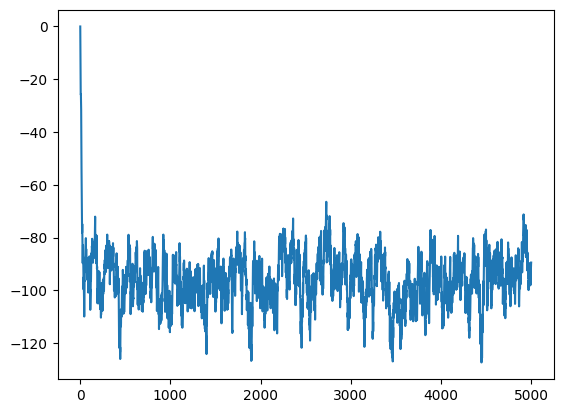

Avg rewards


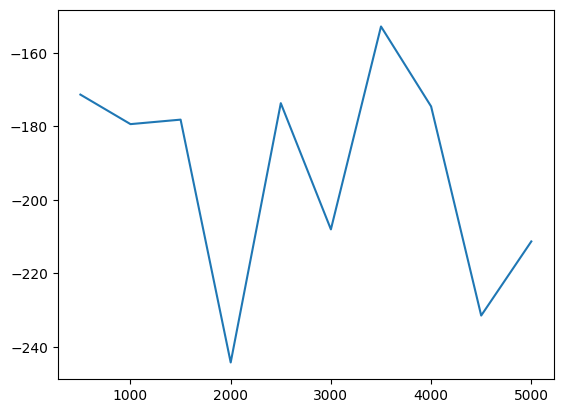

Avg episode lengths


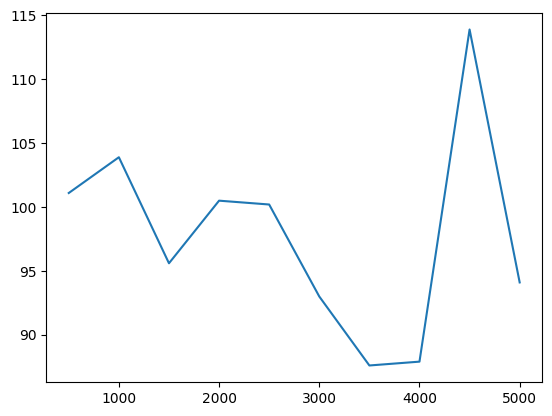

In [15]:
# In the new version of Gymnasium you need different environments for rendering and no rendering.
# Here we instaintiate two versions of cartpole, one that animates the episodes (which slows everything
# down), and another that does not animate.
env = gym.make('LunarLander-v2')
env_render = gym.make('LunarLander-v2', render_mode = 'human')

# Make a policy network.
baseline = True
if baseline:
    policy = LunarPolicyNet(env, hidden_size1=16, hidden_size2=16)
    value_net = LunarValueNet(env, hidden_size1=16, hidden_size2=16)
else:
    policy = PolicyNet(env)

# Check environment
done = False
obs = env_render.reset()
while not done:
    action = random.choice(range(env_render.action_space.n))
    (obs, reward, done, trunc, info)  = env_render.step(action)
    env_render.render()
    
# Train the agent.
num_episodes = 5000
N = 500
running_rewards, avg_rewards, avg_episode_lengths = reinforce(policy, value_net, env, env_render, num_episodes=num_episodes, baseline = baseline, test_every= N, test_episodes=10, use_wandb = True)
# reinforce_with_baseline(policy, value_net, env, env_render, num_episodes=num_episodes, test_every= N, test_episodes=10)
print("Running rewards")
plt.plot(running_rewards)
plt.show()

print("Avg rewards")
# on the x range(1, 200, 100), on the y the avg_rewards
plt.plot(range(N, num_episodes+1, N), avg_rewards)
plt.show()

print("Avg episode lengths")
plt.plot(range(N, num_episodes+1, N), avg_episode_lengths)
plt.show()

# Close up everything
env_render.close()
env.close()

In [15]:
env_render = gym.make('LunarLander-v2', render_mode='human')
for _ in range(10):
    run_episode(env_render, policy, value_net)
    
# If you don't close the environment, the PyGame window stays visible.
env_render.close()